#### 医生平均看诊时间估计

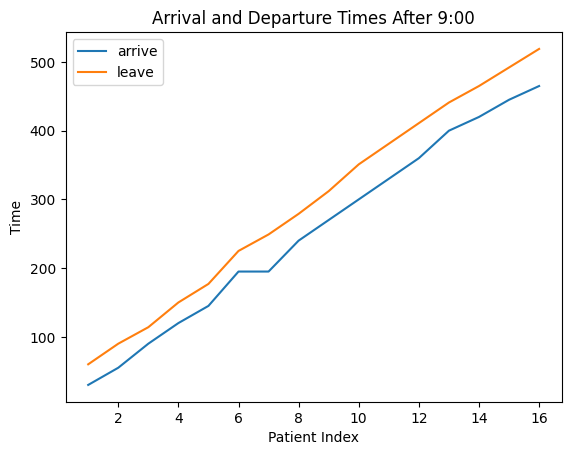

平均花费时间:486.15分钟/天


In [34]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt
def time_cost(patient_num):
    def serve():
        return rd.choices([24, 27, 30, 33, 36, 39],[0.1, 0.2, 0.4, 0.15, 0.10, 0.05])[0]
    def arrive(index):
        return 30*(index+1) + rd.choices([-15, -5, 0, 10, 15], [0.10, 0.25, 0.50, 0.10, 0.05])[0]
    
    ## 初始化信息矩阵
    guests = np.array([[0 for _ in range(patient_num)] for _ in range(5)])
    #["arrive", "serve", "stay", "leave", "option"]
    for index in range(patient_num):
        arrive_time, serve_time = arrive(index), serve()
        if index == 0:
            guests[:,index] = [arrive_time, serve_time, serve_time, arrive_time + serve_time , 0]
        else:
            last_leave = guests[3, index-1]
            if arrive_time >= last_leave:
                guests[:,index] = [arrive_time, serve_time, serve_time, arrive_time + serve_time, 0]
            else:
                wait = guests[3,index-1] - arrive_time
                stay = wait + serve_time
                guests[:,index] = [arrive_time, serve_time, stay, arrive_time + stay, 1]
    return guests
    
def plot_guests(guests):
    patientNum = len(guests[0])
    plt.plot(list(range(1,patientNum+1)), guests[0,:], label = "arrive")
    plt.plot(list(range(1,patientNum+1)), guests[3,:], label = "leave")
    plt.title("Arrival and Departure Times After 9:00")  
    plt.xlabel("Patient Index")  
    plt.ylabel("Time") 
    plt.legend() 
    plt.show()
    return 0
plot_guests(time_cost(16))

def calAveTime(guests):
    time_cost = [guests[1,i] for i in range(len(guests[0]))]
    return sum(time_cost)/len(time_cost)

avelst = []
for _ in range(100):
    avelst.append(calAveTime(time_cost(16)))
ave = sum(avelst)/len(avelst) * 16
    
print("平均花费时间:{}分钟/天".format(ave))
    


#### 评估银行性能

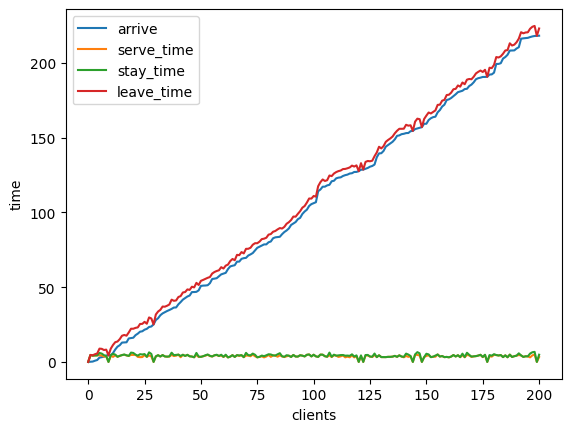

预计逗留时间:4.14
放弃服务概率:0.04
出纳员空闲概率:0.23


In [35]:
from scipy.stats import expon

def bank(clientNum):
    client = [[0 for _ in range(clientNum + 1)] for _ in range(7)]
    # lineName = ["arrive_time", "serving_num", "isquit", "wait_time", "serve_time", "stay_time", "leave_time"]
    
    # 判断是否要放弃服务
    def isQuit(number):
        quit = True
        if number < 6:
            quit = False
        elif number <= 8:
            quit = rd.choices([True, False],[0.2, 0.8])[0]
        elif number <= 10:
            quit = rd.choices([True, False],[0.4, 0.6])[0]
        elif number <= 14:
            quit = rd.choices([True, False],[0.6, 0.4])[0]
        else:
            quit = rd.choices([True, False],[0.8, 0.2])[0]
        return quit
    
    # 获取当前有多少人在服务 (包括队列中的和排队中的)
    def get_serving(index0,arrive_time):
        stay_client_leave_time = [leave_time for leave_time in client[6][index0:] if leave_time > arrive_time]
        serving_num = len(stay_client_leave_time)
        if serving_num == 0:
            return (1, 0, stay_client_leave_time)
        else:
            index0 = client[6][index0:].index(stay_client_leave_time[0])
            return (index0, serving_num, stay_client_leave_time)
     
    
    # 获取服务时间
    def serve():
        return rd.uniform(3,5)
    
    # 一次性生成所有人的arrive-time
    def arrive(client_num):
        lambda_val = 1 # 一分钟平均到达一个
        rv = expon(scale = 1/lambda_val)
        time_gap = rv.rvs(size=client_num)
        arrive_time = [time_gap[0]]
        for i in range(1,len(time_gap)):
            arrive_time.append(arrive_time[i-1] + time_gap[i])
        return arrive_time
        
    # 主循环
    client[0][1:] = arrive(client_num=clientNum) # 生成到达时间
    index0 = 1 # 缩短查询时间
    for index in range(1,clientNum + 1):
        arrive_time = client[0][index]
        result = get_serving(index0,arrive_time=arrive_time)
        index0,serving_num,stay_client_leave_time = result[0],result[1],result[2]
        
        if serving_num < 4:
            isquit = False
            wait_time = 0
            serve_time = serve()
            stay_time = serve_time
            leave_time = arrive_time + stay_time
        else:
            isquit = isQuit(serving_num)
            if isquit:
                isquit = True
                wait_time = 0
                serve_time = 0
                stay_time = 0
                leave_time = arrive_time
            else:
                isquit = False
                wait_time = min(stay_client_leave_time) - arrive_time
                serve_time = serve()
                stay_time = wait_time + serve_time
                leave_time = arrive_time + stay_time
                
        colInfo = [arrive_time, serving_num, isquit, wait_time, serve_time, stay_time, leave_time]
        for i in range(7):
            client[i][index] = colInfo[i]
    return client
    
result = bank(200)

# 绘制折线图
def bankPlot(client):
    x = list(range(len(client[0])))
    plt.plot(x,client[0], label = "arrive")
    plt.plot(x,client[4], label ="serve_time")
    plt.plot(x,client[5], label ="stay_time")
    plt.plot(x,client[6], label ="leave_time")
    plt.xlabel("clients")
    plt.ylabel("time")
    plt.legend()
    plt.show()
    
bankPlot(result)
print("预计逗留时间:{:.2f}".format(np.mean(result[5])))
print("放弃服务概率:{:.2f}".format(sum(result[2])/len(result[2])))
print("出纳员空闲概率:{:.2f}".format(sum([4-i for i in result[1] if i < 4]) / (4*len(result[1]))))



#### 校园卡服务系统评估
只需要将第6题代码中的serve()生成函数做如下改变

In [36]:
def serve():
    rv = expon(scale = 3)
    return rv.rvs()

可以得到如下结果

![outpit](./T9.png)

```
预计等待时间:0.12691845126288007

出纳员忙概率:0.6082089552238805
```

#### [Simpy学习](https://simpy.readthedocs.io/en/latest/)

[模拟了一个银行排队系统中的客户如何到达、等待、服务和可能因等待时间过长而离开的情况](https://simpy.readthedocs.io/en/latest/examples/bank_renege.html)

In [38]:
"""
Bank renege example

Covers:

- Resources: Resource
- Condition events

Scenario:
  A counter with a random service time and customers who renege. Based on the
  program bank08.py from TheBank tutorial of SimPy 2. (KGM)

"""
import random

import simpy


RANDOM_SEED = 42
NEW_CUSTOMERS = 5  # Total number of customers

# 这里的时间不是实际时间，设计成1s，1day，1year都是可以的
INTERVAL_CUSTOMERS = 10.0  # Generate new customers roughly every x seconds

# 设定耐心的限度，等待时间比3大以后就不等了，在请求服务台资源的时候用到
MIN_PATIENCE = 1  # Min. customer patience
MAX_PATIENCE = 3  # Max. customer patience

# 产生number个customer，interval是生成间隔，counter表示服务台
def source(env, number, interval, counter):
    """Source generates customers randomly"""
    for i in range(number):
        # 这里生成了customer，最后一个参数的意思是在counter中平均待了12s
        c = customer(env, 'Customer%02d' % i, counter, time_in_bank=12.0)
        # 相当于在顾客进入了环境。开始模拟
        env.process(c)
        # 相当于隔了时间t下一个用户才过来
        t = random.expovariate(1.0 / interval)
        # yield timeout了时间t，也就是暂停这个函数t时间，模拟了下一个for i产生的时刻
        yield env.timeout(t)


def customer(env, name, counter, time_in_bank):
    """Customer arrives, is served and leaves."""
    # env环境中现在的时间
    arrive = env.now
    print('%7.4f %s: Here I am' % (arrive, name))

    with counter.request() as req:
        # 每个customer的耐心处在3-5之间，用均匀分布生成
        patience = random.uniform(MIN_PATIENCE, MAX_PATIENCE)
        # Wait for the counter or abort at the end of our tether
        # ｜ 是或者的意思，也就是要么请求到了counter，要么就timeout
        results = yield req | env.timeout(patience)
        # 此时已经等待的时间
        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
            # 进入counter花费的时间，使用yield停止env tib时间，模拟服务过程发生的时间
            tib = random.expovariate(1.0 / time_in_bank)
            yield env.timeout(tib)
            print('%7.4f %s: Finished' % (env.now, name))

        else:
            # We reneged
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))

# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
# 只有一个counter
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()

Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 3.8595 Customer00: Finished
10.2006 Customer01: Here I am
10.2006 Customer01: Waited  0.000
12.7265 Customer02: Here I am
13.9003 Customer02: RENEGED after  1.174
23.7507 Customer01: Finished
34.9993 Customer03: Here I am
34.9993 Customer03: Waited  0.000
37.9599 Customer03: Finished
40.4798 Customer04: Here I am
40.4798 Customer04: Waited  0.000
43.1401 Customer04: Finished
